In [ ]:
import os
import matplotlib.image as img
import numpy as np
import cv2


def loadimgs(path,n = 0):
    '''
    path => Path of train directory or test directory
    '''
    X=[]
    y=[]
    
    lang_dict = {}
    curr_y = n
    category_images=[]
    
    # we load every alphabet seperately so we can isolate them later
    for filename in os.listdir(path):
        print("loading filename: " + filename)
        lang_dict[filename] = curr_y
        image_path = os.path.join(path, filename)
        image = cv2.imread(image_path)
        image_copy = cv2.resize(image, dsize=(210, 210),interpolation=cv2.INTER_LINEAR)
        category_images.append(image_copy)
        y.append(curr_y)
        curr_y += 1
      
      
      
      # X.append(np.stack(category_images))
    try :
        X.append(np.stack(category_images))
    # edge case  - last one
    except ValueError as e:
        print(e)
        print("error - category_images:", category_images)
    
    
    y = np.vstack(y)
    X = np.stack(X)
    return X,y,lang_dict

# Model 구축

In [1]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

Using TensorFlow backend.


In [2]:
class SmallerVGGNet:
    @staticmethod
    def build(width, height, depth, classes, finalAct="sigmoid"):
        # 인풋 이미지의 차원과, 채널에 해당하는 축을 설정하여 모델을 초기화합니다
        # "channels_last"는 채널의 축이 마지막에 오는 것을 의미합니다
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1

        # 만약 "channels_first"를 사용한다면, 인풋 이미지의 차원을
        # 그에 맞게 바꿔줍니다
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1
            
        # CONV => RELU => POOL
        model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(3, 3)))
        model.add(Dropout(0.25))

        # (CONV => RELU) * 2 => POOL
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # (CONV => RELU) * 2 => POOL
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # FC => RELU
        model.add(Flatten())
        model.add(Dense(1024))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # 단일 라벨 분류는 *softmax* 활성화 함수를 사용합니다
        # 다중 라벨 분류는 *sigmoid* 활성화 함수를 사용합니다
        model.add(Dense(classes))
        model.add(Activation(finalAct))

        # 네트워크 아키텍처를 반환합니다
        return model

In [3]:
# matplotlib의 백엔드를 설정하여 그림이 백그라운드에서 저장될 수 있게합니다
import matplotlib

# 필요한 패키지들을 가져옵니다
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from pyimagesearch.smallervggnet import SmallerVGGNet
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import argparse
import random
import pickle
import cv2
import os

In [11]:
# construct the argument parse and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--dataset", required=True,
	help="path to input dataset (i.e., directory of images)")
ap.add_argument("-m", "--model", required=True,
	help="path to output model")
ap.add_argument("-l", "--labelbin", required=True,
	help="path to output label binarizer")
ap.add_argument("-p", "--plot", type=str, default="plot.png",
	help="path to output accuracy/loss plot")
args = vars(ap.parse_args())

usage: ipykernel_launcher.py [-h] -d DATASET -m MODEL -l LABELBIN [-p PLOT]
ipykernel_launcher.py: error: the following arguments are required: -d/--dataset, -m/--model, -l/--labelbin


SystemExit: 2

In [4]:
# 학습을 위해 에폭과 초기 학습률, 배치 사이즈, 그리고 이미지의 차원을 초기화합니다
EPOCHS = 75
INIT_LR = 1e-3
BS = 32
IMAGE_DIMS = (160, 280, 3)

In [5]:

# args = ap.parse_args()
# 이미지 경로를 섞어줍니다
print("[INFO] loading images...")
imagePaths = sorted(list(paths.list_images('./final_image')))
random.seed(42)
random.shuffle(imagePaths)
 
# 데이터와 라벨을 초기화합니다
data = []
labels = []

[INFO] loading images...


In [6]:
imagePaths

['./final_image\\circle_white\\20969.jpg',
 './final_image\\circle_white\\13003.jpg',
 './final_image\\rectangle_white\\6268.jpg',
 './final_image\\ellipse_brown\\1673.jpg',
 './final_image\\rectangle_yellow\\22179.jpg',
 './final_image\\rectangle_brown\\1962.jpg',
 './final_image\\rectangle_pink\\8292.jpg',
 './final_image\\circle_yellow\\22872.jpg',
 './final_image\\circle_white\\8133.jpg',
 './final_image\\circle_white\\8544.jpg',
 './final_image\\triangle_white\\13404.jpg',
 './final_image\\rectangle_pink\\1707.jpg',
 './final_image\\circle_white\\3720.jpg',
 './final_image\\rectangle_red\\9156.jpg',
 './final_image\\ellipse_white\\13455.jpg',
 './final_image\\circle_white\\4434.jpg',
 './final_image\\rectangle_wine\\11005.jpg',
 './final_image\\triangle_white\\15742.jpg',
 './final_image\\circle_white\\2979.jpg',
 './final_image\\ellipse_red\\22708.jpg',
 './final_image\\circle_white\\3880.jpg',
 './final_image\\ellipse_orange\\13742.jpg',
 './final_image\\rectangle_blue\\3595.jpg

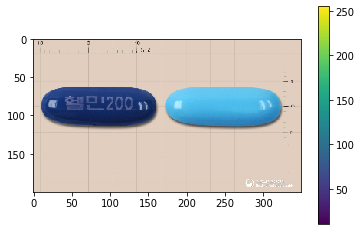

(<matplotlib.image.AxesImage at 0x28d0a95b888>,
 None)

In [55]:
#샘플확인
image = cv2.imread('image\\rectangle_brown\\139.jpg')
image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
plt.imshow(image),plt.colorbar(),plt.show()

In [7]:
for imagePath in imagePaths:
    # 이미지를 로드하고, 전처리한 후 데이터 리스트에 저장합니다
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    image = img_to_array(image)
    data.append(image)

    # 이미지 경로에서 라벨을 추출한 후, 라벨 리스트를 업데이트합니다
    l = label = imagePath.split(os.path.sep)[-2].split("_")
    labels.append(l)

data = np.array(data, dtype= np.float32) / 255.0
labels = np.array(labels)

In [8]:
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(labels)
# labels_test = mlb.fit_transform(label_test)
 
# 나올 수 있는 모든 라벨들을 출력합니다
for (i, label) in enumerate(mlb.classes_):
	print("{}. {}".format(i + 1, label))

1. a hemicyclea semicircle
2. black
3. blue
4. blue, light
5. blue, transparency
6. bluish green
7. bluish green, transparency
8. brown
9. brown, transparency
10. circle
11. dark blue
12. dark blue, transparency
13. diamond
14. ellipse
15. gray
16. green
17. green, transparency
18. hexagon
19. octagon
20. orange
21. orange, transparency
22. pentagon
23. pink
24. pink, deep
25. pink, light
26. pink, transparency
27. purple
28. purple, transparency
29. rectangle
30. red
31. red, transparency
32. tetragon
33. transparency
34. triangle
35. white
36. white, blue
37. white, brown
38. white, green
39. white, red
40. white, transparency
41. white, yellow
42. wine
43. wine, transparency
44. yellow
45. yellow, transparency
46. yellowish green
47. yellowish green, transparency


In [9]:
(trainX, testX, trainY, testY) = train_test_split(data,
	labels, test_size=0.1, random_state=42)

np.savez('./train_data.npz', xtrain = trainX, ytrain = trainY)
np.savez('./test_data.npz', xtest = testX, ytest = testY)

In [10]:
# 데이터의 80%를 학습에, 나머지 20%를 테스트에 사용하기 위해
# 데이터를 나누는 과정입니다
(trainX, testX, trainY, testY) = train_test_split(data,
	labels, test_size=0.2, random_state=42)

aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
	height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
	horizontal_flip=True, fill_mode="nearest")
 


In [11]:
# 다중 라벨 분류를 수행할 수 있도록 sigmoid 활성화 함수를
# 네트워크의 마지막 레이어로 설정합니다
print("[INFO] compiling model...")
model = SmallerVGGNet.build(
	width=IMAGE_DIMS[1], height=IMAGE_DIMS[0],
	depth=IMAGE_DIMS[2], classes=len(mlb.classes_),
	finalAct="sigmoid")

# 옵티마이저를 초기화합니다
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

[INFO] compiling model...


In [ ]:
# 각각의 결과 라벨을 독립적인 베르누이 분포로 취급하기 위해
# 범주형 교차 엔트로피 대신 이진 교차 엔트로피를 사용하여 모델을 컴파일합니다
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
 
# 네트워크를 학습시킵니다
print("[INFO] training network...")
H = model.fit_generator(
	aug.flow(trainX, trainY, batch_size=BS),
	validation_data=(testX, testY),
	steps_per_epoch=len(trainX) // BS,
	epochs=EPOCHS, verbose=1)

[INFO] training network...
Epoch 1/75
 14/540 [..............................] - ETA: 18:29 - loss: 0.8767 - accuracy: 0.5285

In [ ]:
# 모델을 디스크에 저장합니다
print("[INFO] serializing network...")
model.save(args["model"])
 
# `MultiLabelBinarizer`를 디스크에 저장합니다
print("[INFO] serializing label binarizer...")
f = open(args["labelbin"], "wb")
f.write(pickle.dumps(mlb))
f.close()

In [ ]:
# 학습 로스와 정확도를 그래프로 그려줍니다
plt.style.use("ggplot")
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.savefig(args["plot"])